# Introduction

## Context 

In [1]:
# TODO: brief overview of projet goals

## Imports

In [2]:
import math

# graphs
import matplotlib.pyplot as plt

# other libraries
import missingno as msno

# data
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

# preprocessing
from sklearn.preprocessing import LabelEncoder

# graphic settings
sns.set()

## Data imports

* Dataset consists of one main table and 6 extra tables linked by ids
    * `application_test` has no `TARGET` column, will only be used for data drift detection 
* For our Minimum Viable Product we will only use the main table
* Once the MVP is running, other tables could be used to improve model predictions.
* 


![](../references/home_credit.png)

In [3]:
# TODO: use other tables
app_train = pd.read_csv("../data/raw/application_train.csv", index_col="SK_ID_CURR")
# app_test = pd.read_csv("../data/raw/application_test.csv", index_col="SK_ID_CURR")

### Bureau

In [4]:
bureau = pd.read_csv("../data/raw/bureau.csv", index_col="SK_ID_CURR")

In [5]:
bureau.describe()

,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [6]:
bureau.dtypes.value_counts()

float64    8
int64      5
object     3
Name: count, dtype: int64

In [7]:
bureau.select_dtypes("object").nunique()

CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

In [8]:
bureau.shape

(1716428, 16)

In [9]:
app_train.shape

(307511, 121)

In [10]:
# app_train.join(bureau, rsuffix="bureau", how="left")

# First look at data

### Shape, dtypes etc

In [11]:
app_train.shape

(307511, 121)

In [12]:
app_train.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Data columns (total 121 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    TARGET                        307511 non-null  int64  
 1    NAME_CONTRACT_TYPE            307511 non-null  object 
 2    CODE_GENDER                   307511 non-null  object 
 3    FLAG_OWN_CAR                  307511 non-null  object 
 4    FLAG_OWN_REALTY               307511 non-null  object 
 5    CNT_CHILDREN                  307511 non-null  int64  
 6    AMT_INCOME_TOTAL              307511 non-null  float64
 7    AMT_CREDIT                    307511 non-null  float64
 8    AMT_ANNUITY                   307499 non-null  float64
 9    AMT_GOODS_PRICE               307233 non-null  float64
 10   NAME_TYPE_SUITE               306219 non-null  object 
 11   NAME_INCOME_TYPE              307511 non-null  object 
 12   NAME_EDUCATION_TYPE         

To many columns to read each definition, let's group them by dtypes

In [13]:
# Column by dtypes
app_train.dtypes.value_counts()

float64    65
int64      40
object     16
Name: count, dtype: int64

In [14]:
# number of classes for categorical features
app_train.select_dtypes("object").nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [15]:
# Sample preview
app_train.sample(10)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
218653,0,Cash loans,F,N,Y,0,42750.0,688090.5,24844.5,594000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
409425,0,Cash loans,F,N,N,0,130500.0,390960.0,27337.5,337500.0,...,0,0,0,0,0.0,0.0,0.0,2.0,2.0,0.0
353953,0,Cash loans,F,N,Y,0,90000.0,643500.0,20889.0,643500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
302089,0,Cash loans,F,Y,Y,0,900000.0,1442434.5,79173.0,1377000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0
292816,0,Cash loans,M,N,Y,0,202500.0,269550.0,16510.5,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
178278,0,Revolving loans,M,Y,N,0,112500.0,180000.0,9000.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
339634,0,Cash loans,F,Y,N,0,157500.0,1642500.0,43326.0,1642500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0
211814,0,Cash loans,M,Y,Y,1,225000.0,314055.0,17167.5,238500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
377126,0,Cash loans,M,N,N,0,216000.0,891126.0,48474.0,796500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


## Get variable definitions 

In [16]:
# Load description file
feature_description = pd.read_csv(
    "../data/raw/HomeCredit_columns_description.csv", encoding="unicode_escape"
)
feature_description = feature_description.set_index("Row")[
    ["Description", "Special", "Table"]
]


def get_definition(feature):
    """
    Prints definition of a feature. Not sensitive to case.

    Parameters
    ----------
    feature: str
        Name of the feature
    """
    with pd.option_context("display.max_colwidth", None):
        display(pd.DataFrame(feature_description.loc[feature.upper(), :]))


get_definition("APARTMENTS_MODE")

,APARTMENTS_MODE
Description,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
Special,normalized
Table,application_{train|test}.csv


## Describe

In [17]:
app_train_desc = app_train.describe().T
with pd.option_context(
    "display.max_row", None, "display.float_format", "{:20,.2f}".format
):
    display(app_train_desc)

,count,mean,std,min,25%,50%,75%,max
TARGET,"307,511.00",0.08,0.27,0.00,0.00,0.00,0.00,1.00
CNT_CHILDREN,"307,511.00",0.42,0.72,0.00,0.00,0.00,1.00,19.00
AMT_INCOME_TOTAL,"307,511.00","168,797.92","237,123.15","25,650.00","112,500.00","147,150.00","202,500.00","117,000,000.00"
AMT_CREDIT,"307,511.00","599,026.00","402,490.78","45,000.00","270,000.00","513,531.00","808,650.00","4,050,000.00"
AMT_ANNUITY,"307,499.00","27,108.57","14,493.74","1,615.50","16,524.00","24,903.00","34,596.00","258,025.50"
AMT_GOODS_PRICE,"307,233.00","538,396.21","369,446.46","40,500.00","238,500.00","450,000.00","679,500.00","4,050,000.00"
REGION_POPULATION_RELATIVE,"307,511.00",0.02,0.01,0.00,0.01,0.02,0.03,0.07
DAYS_BIRTH,"307,511.00","-16,037.00","4,363.99","-25,229.00","-19,682.00","-15,750.00","-12,413.00","-7,489.00"
DAYS_EMPLOYED,"307,511.00","63,815.05","141,275.77","-17,912.00","-2,760.00","-1,213.00",-289.00,"365,243.00"
DAYS_REGISTRATION,"307,511.00","-4,986.12","3,522.89","-24,672.00","-7,479.50","-4,504.00","-2,010.00",0.00


## Missing values

app_train.info()

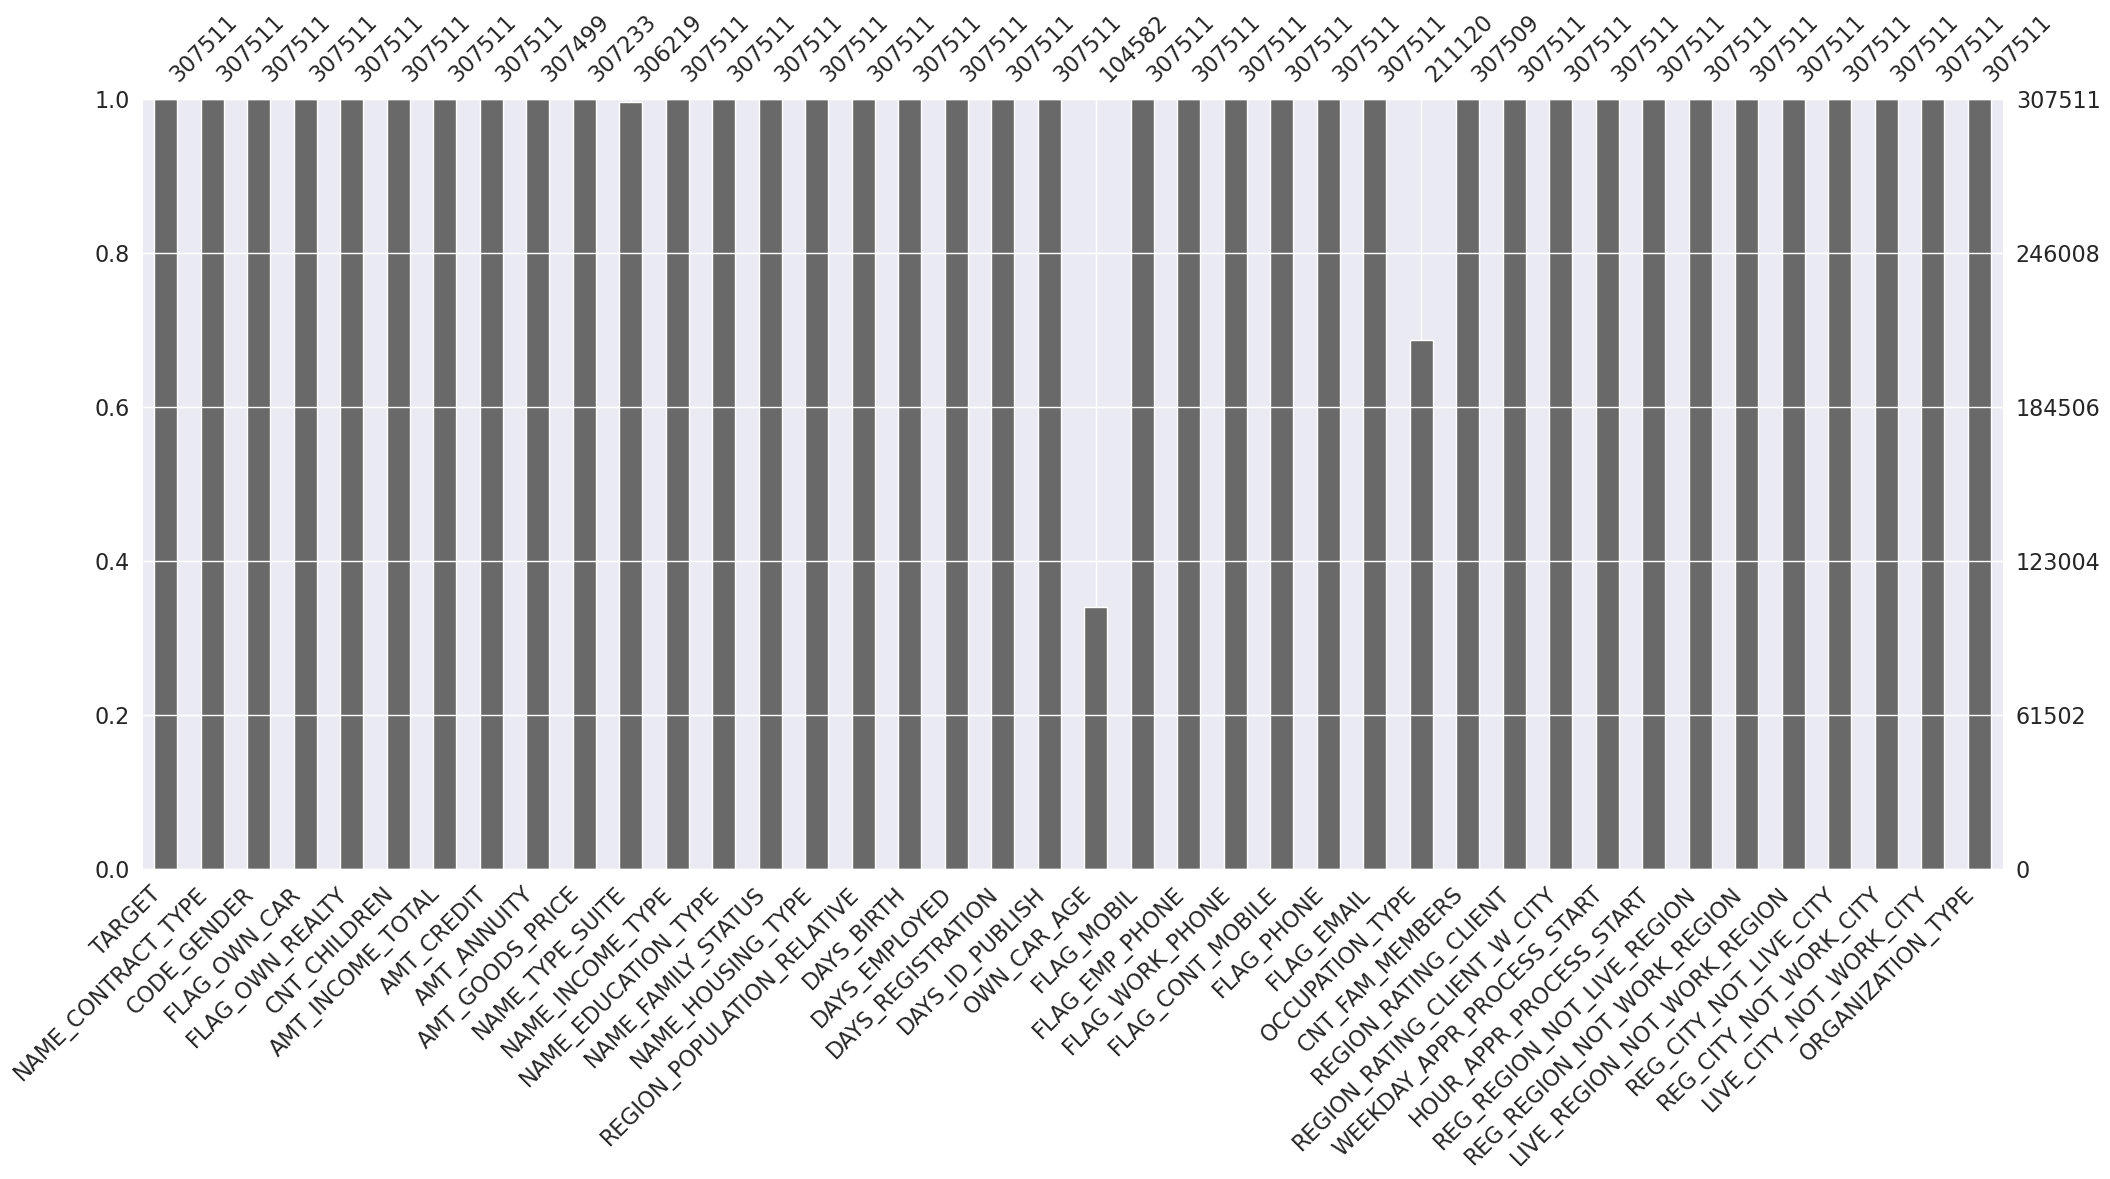

In [18]:
# df divided in 3 plots because msno has a 50 column limit (issue with matplotlib version)
msno.bar(app_train.iloc[:, :40]);

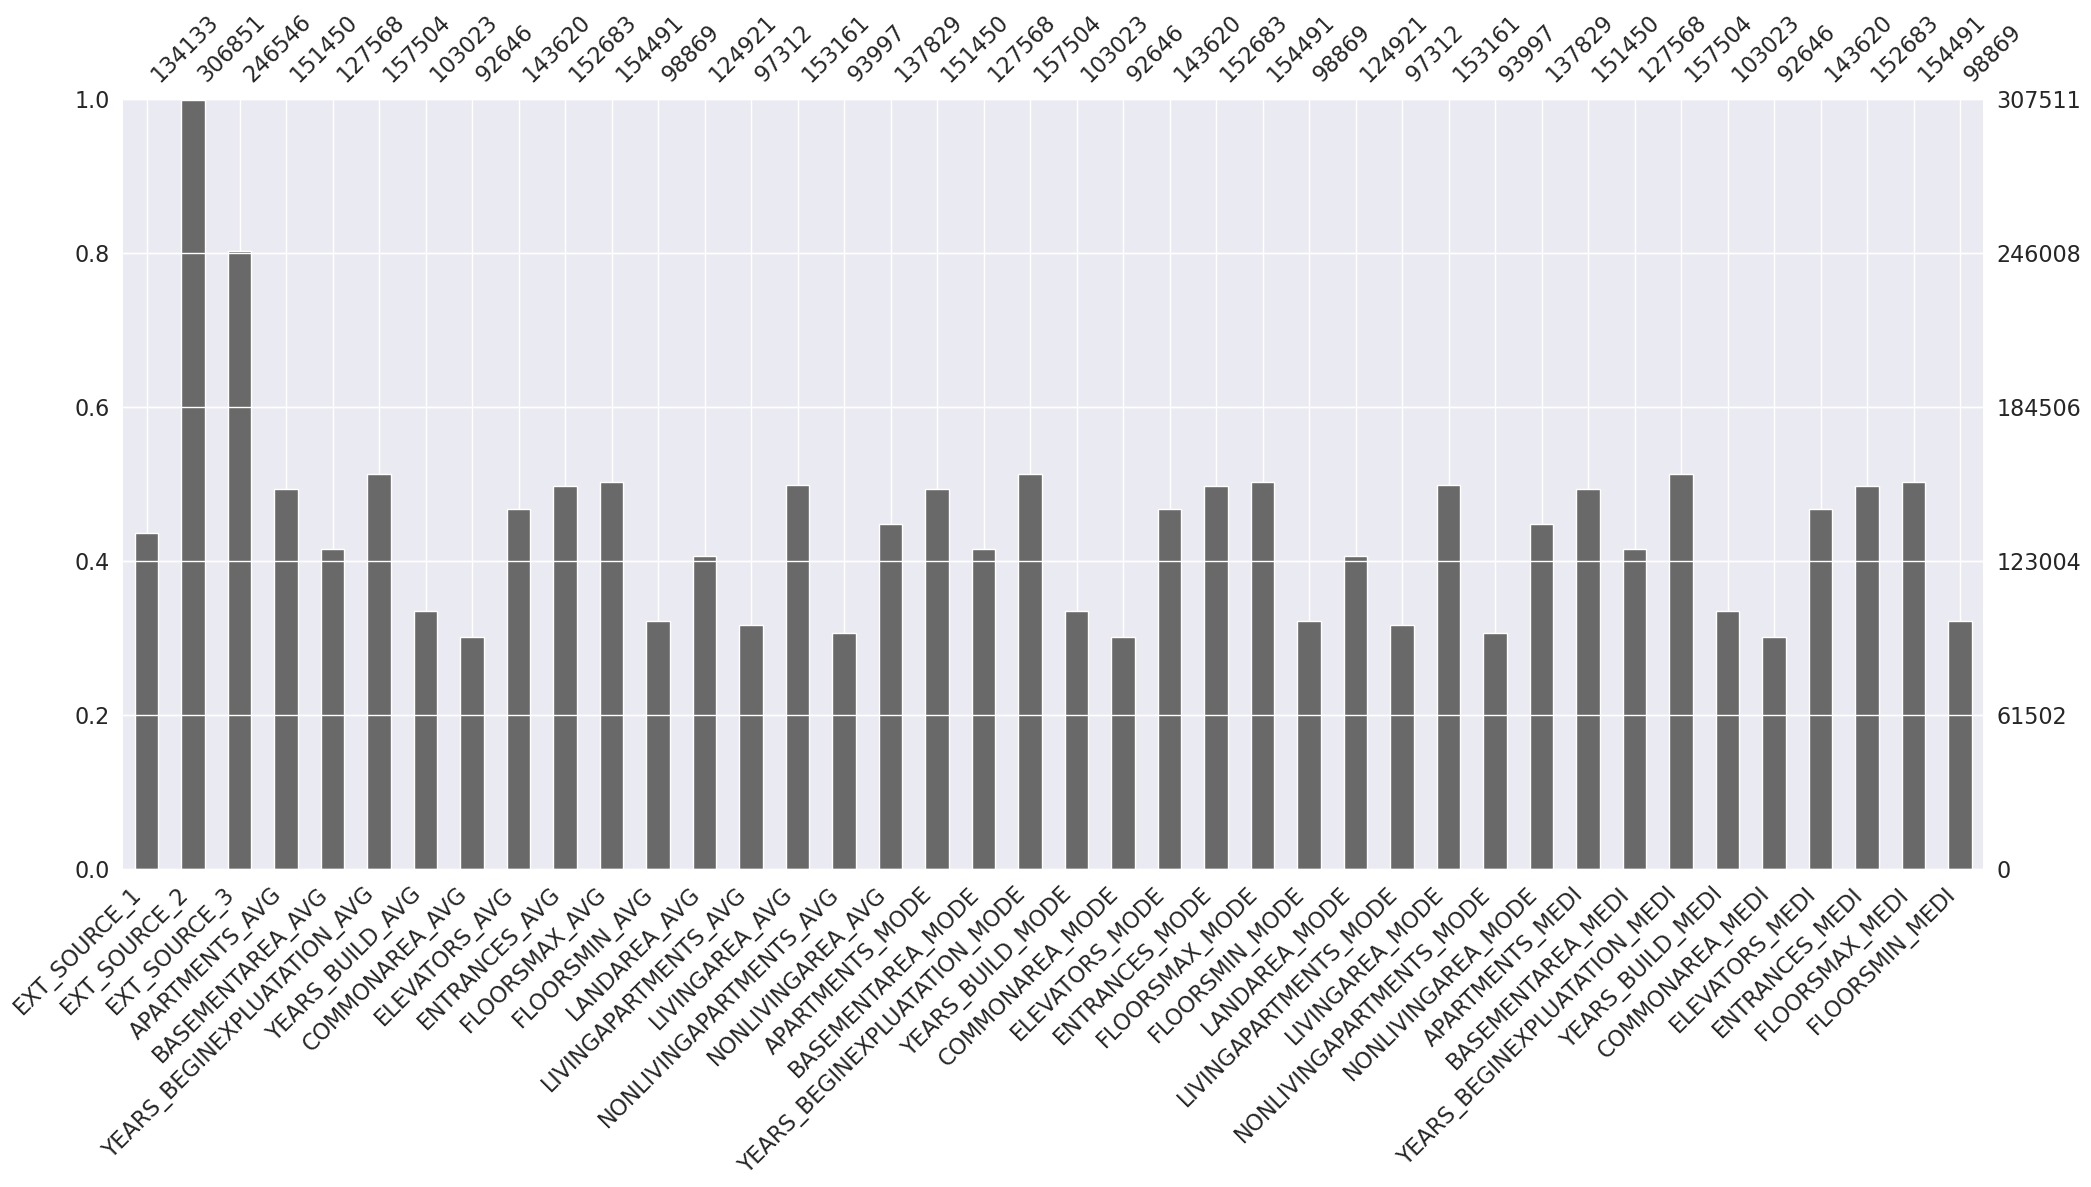

In [19]:
msno.bar(app_train.iloc[:, 40:80]);

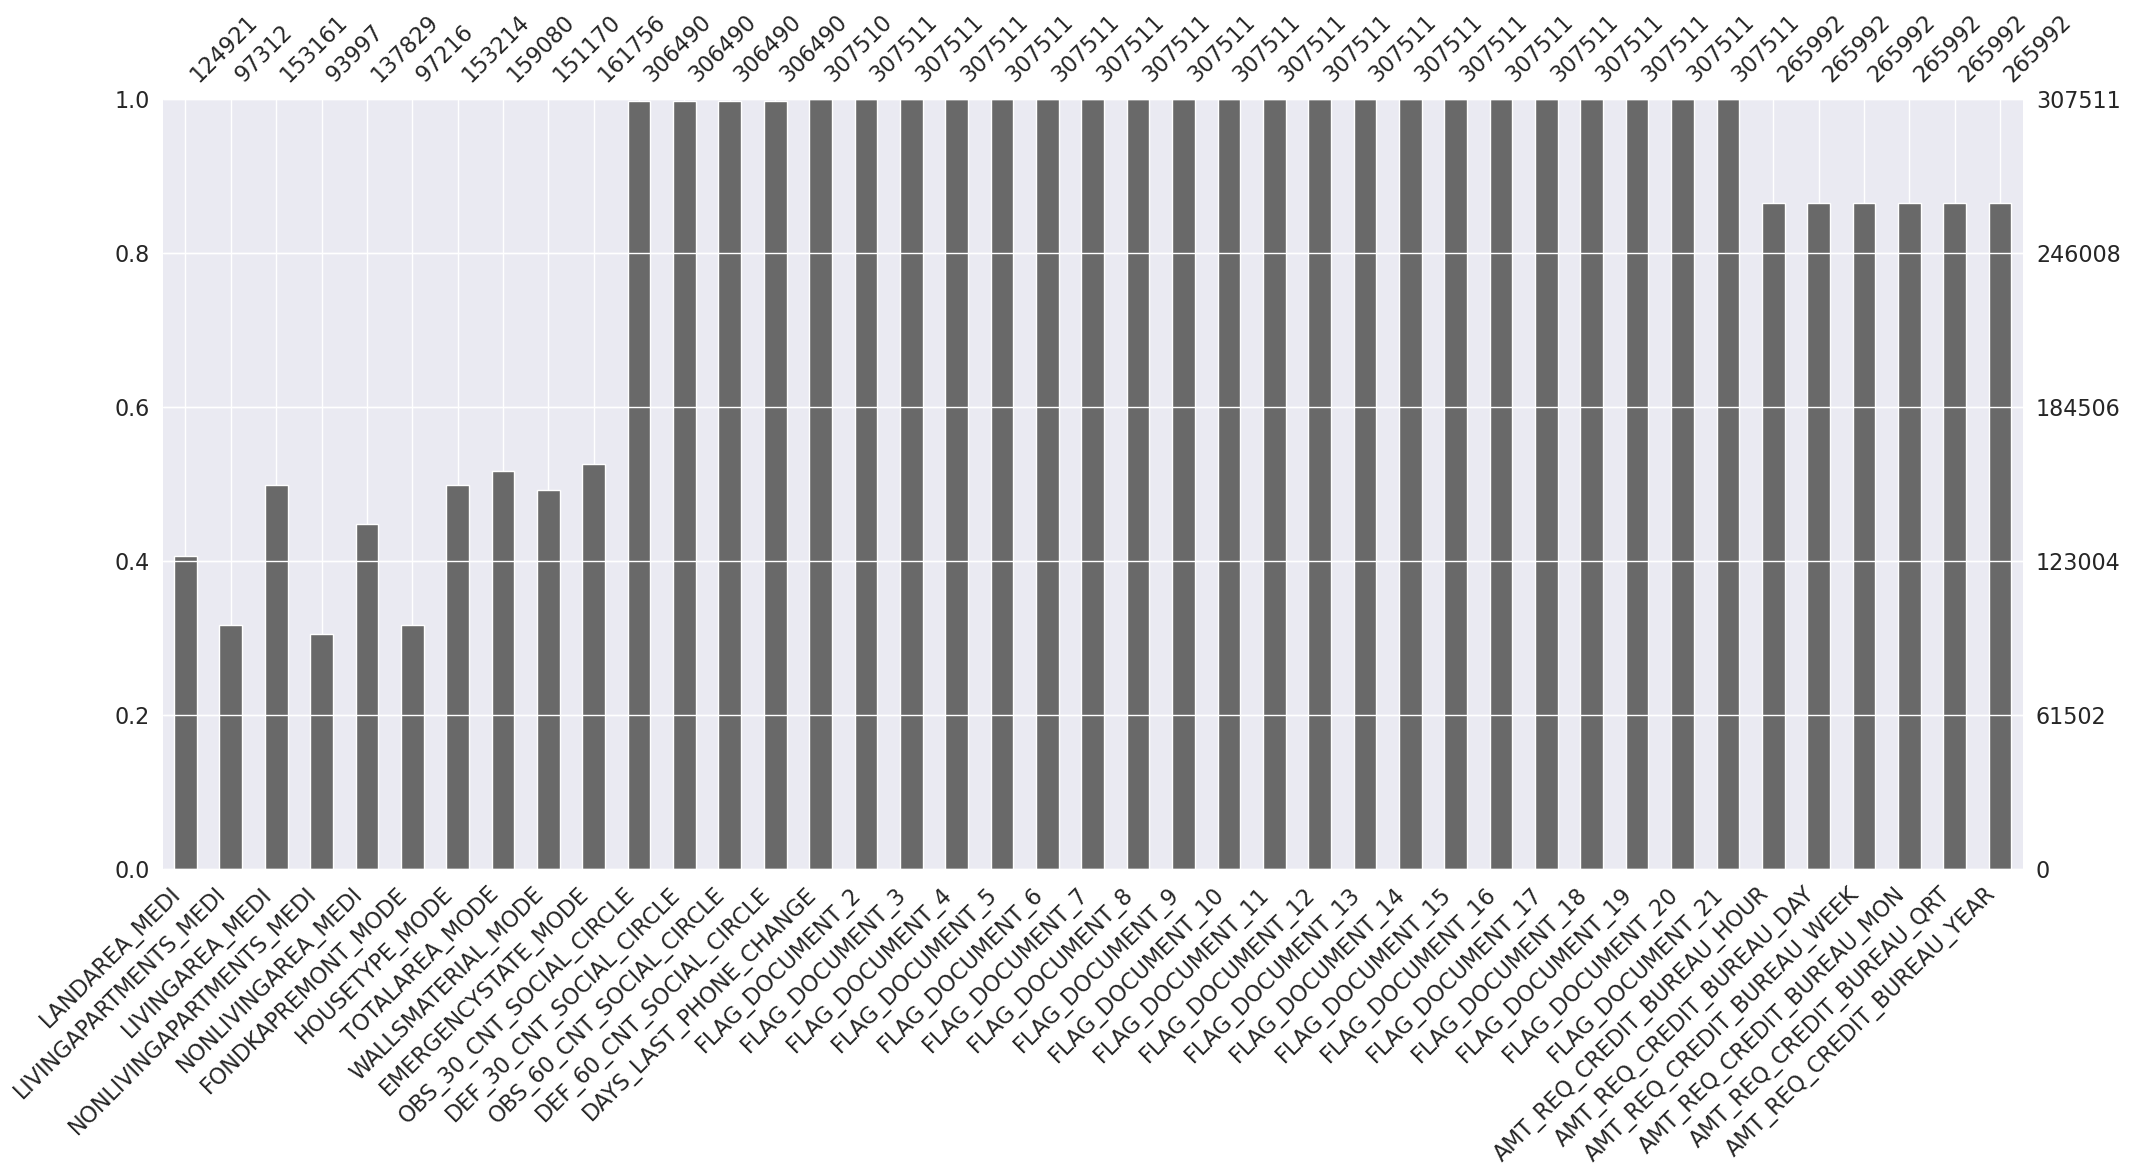

In [20]:
msno.bar(app_train.iloc[:, 80:]);

In [21]:
# Columns that are the most empty
tmp = app_train.isna().mean().sort_values(ascending=False).head(20)
tmp

COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_MEDI             0.698723
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MODE       0.683550
FLOORSMIN_AVG               0.678486
FLOORSMIN_MODE              0.678486
FLOORSMIN_MEDI              0.678486
YEARS_BUILD_AVG             0.664978
YEARS_BUILD_MEDI            0.664978
YEARS_BUILD_MODE            0.664978
OWN_CAR_AGE                 0.659908
LANDAREA_MEDI               0.593767
LANDAREA_AVG                0.593767
LANDAREA_MODE               0.593767
dtype: float64

<div class="alert alert-block alert-warning">
<b>Comment : </b></div>

most of the columns contain NaN. We don't know yet which features are important, we will keep them all for now.

## Duplicates

In [22]:
app_train.index.duplicated().any()

False

In [23]:
app_train.duplicated().any()

False

## Outliers and anomalies

### Z-score and boxplot detection

AMT_INCOME_TOTAL              492.703449
AMT_REQ_CREDIT_BUREAU_QRT     350.470589
OBS_30_CNT_SOCIAL_CIRCLE      144.506214
OBS_60_CNT_SOCIAL_CIRCLE      144.117631
AMT_REQ_CREDIT_BUREAU_MON      31.242339
CNT_CHILDREN                   25.733871
CNT_FAM_MEMBERS                19.597532
AMT_ANNUITY                    15.931509
AMT_REQ_CREDIT_BUREAU_YEAR     12.585586
OWN_CAR_AGE                     9.645167
AMT_GOODS_PRICE                 9.501557
AMT_CREDIT                      8.574059
DAYS_REGISTRATION               5.588007
DAYS_LAST_PHONE_CHANGE          4.026504
HOUR_APPR_PROCESS_START         3.693833
DAYS_ID_PUBLISH                 2.784328
DAYS_EMPLOYED                   2.133617
DAYS_BIRTH                      2.106335
dtype: float64


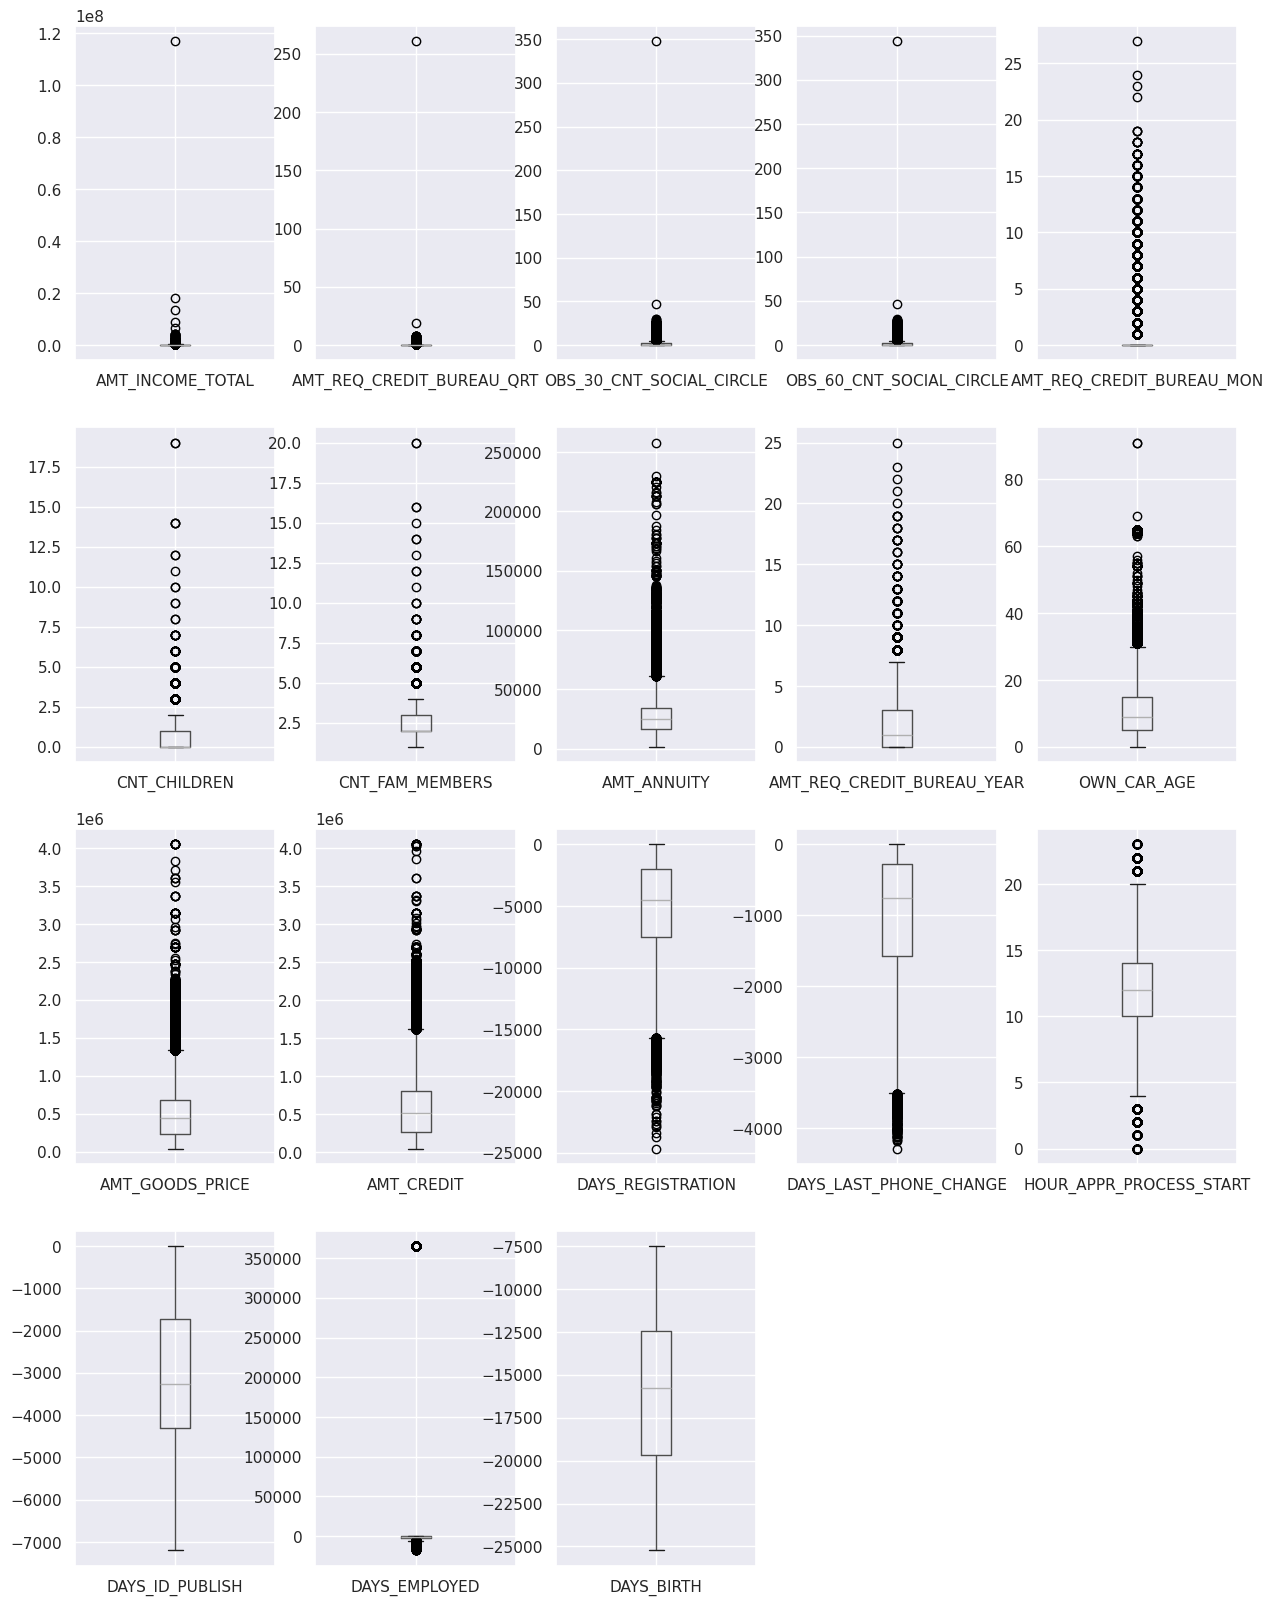

In [24]:
# Print boxplots for all numeric features
# filter out categorial num features
num_col = app_train.select_dtypes(np.number).nunique() > 10
num_col = num_col[num_col].index

# filter features with 0 to 1 values
bool_features = (app_train[num_col].max() - app_train[num_col].min()) <= 1
not_bool_features = bool_features[~bool_features].index

# select features with high Z-Score
feature_has_outliers = (
    scipy.stats.zscore(app_train[not_bool_features].fillna(0)).abs().max()
).sort_values(ascending=False)
feature_has_outliers = feature_has_outliers[feature_has_outliers > 2]

subset = feature_has_outliers.index
PLOT_LINES = len(subset)
PLOT_COL = 5
plt.figure(figsize=(15, 20))
for i, col in enumerate(app_train[subset]):
    plt.subplot(PLOT_LINES // PLOT_COL + 1, PLOT_COL, i + 1)
    app_train.boxplot(column=col)

print(feature_has_outliers.sort_values(ascending=False))

<div class="alert alert-block alert-warning">
<b>Comment : </b></div>

Detected outliers :
- `AMT_INCOME_TOTAL` : outlier but possibly real value
- `AMT_REQ_CREDIT_BUREAU_QRT` : outlier but possibly real value
- `OBS_30_CNT_SOCIAL_CIRCLE` : outlier but possibly real value
- `OBS_60_CNT_SOCIAL_CIRCLE` : outlier but possibly real value
- `DAYS_EMPLOYED` : impossible value, needs fixing


In [25]:
get_definition("OBS_30_CNT_SOCIAL_CIRCLE")

,OBS_30_CNT_SOCIAL_CIRCLE
Description,How many observation of client's social surroundings with observable 30 DPD (days past due) default
Special,NaN
Table,application_{train|test}.csv


### Impossible values

In [26]:
# Detect features with both positive and negative values
values_positive_and_negative = (
    app_train.select_dtypes(np.number).min() * app_train.select_dtypes(np.number).max()
) < 0
values_positive_and_negative[values_positive_and_negative]

DAYS_EMPLOYED    True
dtype: bool

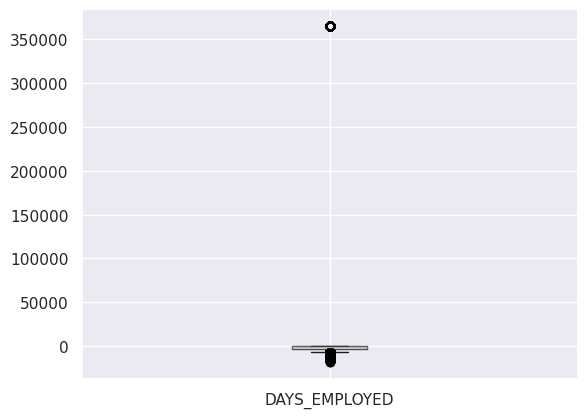

In [27]:
app_train.boxplot(column="DAYS_EMPLOYED");

### By column name

In [28]:
def cols_containing(pattern: str):
    """
    Returns list of column names that contain a pattern.

    Parameters
    ----------
    pattern: str
        Pattern to look for in column names. Case insensitive.

    Returns
    -------
    List
        List of column names

    """
    return app_train.columns[app_train.columns.str.contains(pattern.upper())].to_list()

In [29]:
# convert negative days to years
(app_train[cols_containing("days")] / -365).describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
count,307511.000000,307511.000000,307511.000000,307511.000000,307510.000000
mean,43.936973,-174.835742,13.660604,8.203294,2.637969
std,11.956133,387.056895,9.651743,4.135481,2.265229
min,20.517808,-1000.665753,-0.000000,-0.000000,-0.000000
25%,34.008219,0.791781,5.506849,4.712329,0.750685
50%,43.150685,3.323288,12.339726,8.915068,2.073973
75%,53.923288,7.561644,20.491781,11.778082,4.301370
max,69.120548,49.073973,67.594521,19.717808,11.758904


<div class="alert alert-block alert-danger">
<b>Comment : </b>Min value of -1000 years employed is impossible, is it a single outlier or a common value?</div>

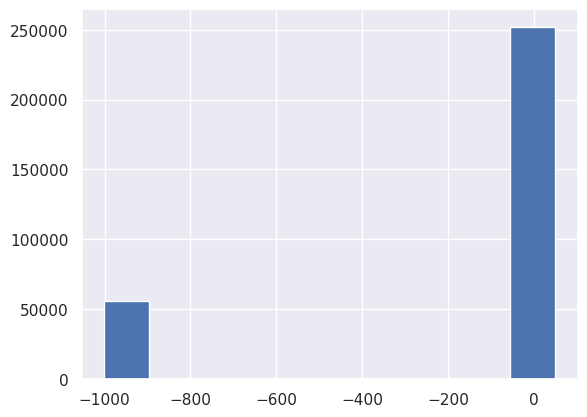

In [30]:
(app_train.DAYS_EMPLOYED / -365).hist();

In [31]:
# check for impossible values in time variables
app_train[cols_containing("year")].describe()

,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,AMT_REQ_CREDIT_BUREAU_YEAR
count,157504.000000,103023.000000,157504.000000,103023.000000,157504.000000,103023.000000,265992.000000
mean,0.977735,0.752471,0.977065,0.759637,0.977752,0.755746,1.899974
std,0.059223,0.113280,0.064575,0.110111,0.059897,0.112066,1.869295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.976700,0.687200,0.976700,0.699400,0.976700,0.691400,0.000000
50%,0.981600,0.755200,0.981600,0.764800,0.981600,0.758500,1.000000
75%,0.986600,0.823200,0.986600,0.823600,0.986600,0.825600,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.000000


# Cleaning
Main table is already split in train/test, so we will apply the same cleaning process to both

## Fixing Outliers

In [32]:
#  Main table is already split in train/test, so we will apply the same cleaning process to both
# Replace Outliers value by imputing NaN and add flag to keep track
# train
app_train["FLAG_ANOMALY_DAYS_EMPLOYED"] = app_train.DAYS_EMPLOYED > 365 * 100
outlier_value = app_train.DAYS_EMPLOYED.max()
app_train.DAYS_EMPLOYED.replace(outlier_value, np.nan, inplace=True)

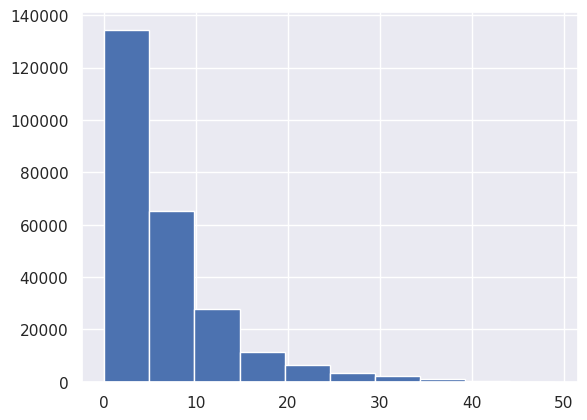

In [33]:
(app_train.DAYS_EMPLOYED / -365).hist();

In [34]:
app_train[(app_train.AMT_INCOME_TOTAL > 1000000)].AMT_INCOME_TOTAL.shape

(250,)

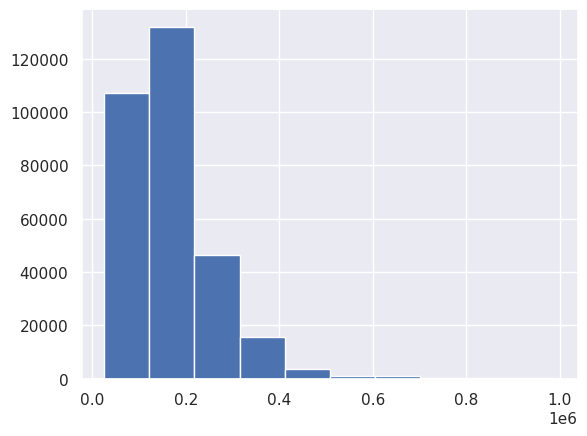

In [35]:
# Print dist of AMT_INCOME_TOTAL without extreme outliers for better visibility
app_train[(app_train.AMT_INCOME_TOTAL < 1000000)].AMT_INCOME_TOTAL.hist();

# Feature engineering

## Financial features using Kaggle Kernel

In [36]:
# from https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features
# Some simple new features (percentages)
app_train["FE_DAYS_EMPLOYED_PERC"] = (
    app_train["DAYS_EMPLOYED"] / app_train["DAYS_BIRTH"]
)
app_train["FE_INCOME_CREDIT_PERC"] = (
    app_train["AMT_INCOME_TOTAL"] / app_train["AMT_CREDIT"]
)
app_train["FE_INCOME_PER_PERSON"] = (
    app_train["AMT_INCOME_TOTAL"] / app_train["CNT_FAM_MEMBERS"]
)
app_train["FE_ANNUITY_INCOME_PERC"] = (
    app_train["AMT_ANNUITY"] / app_train["AMT_INCOME_TOTAL"]
)
app_train["FE_PAYMENT_RATE"] = app_train["AMT_ANNUITY"] / app_train["AMT_CREDIT"]

# Graphical analysis

## Target

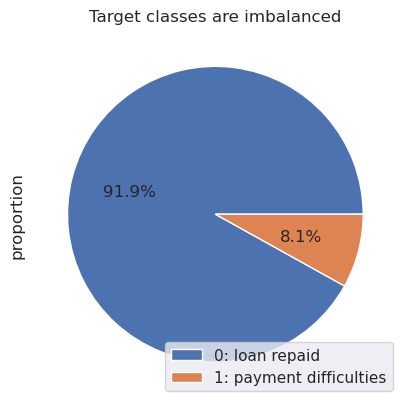

In [37]:
# Target
app_train.TARGET.value_counts(normalize=True).plot(
    kind="pie",
    autopct="%1.1f%%",
    labels=None,
    title="Target classes are imbalanced",
)
plt.legend(["0: loan repaid", "1: payment difficulties"], loc="lower right")
plt.show()

## Bivariate analysis vs TARGET

### Categorical features

#### Low cardinality (few classes)

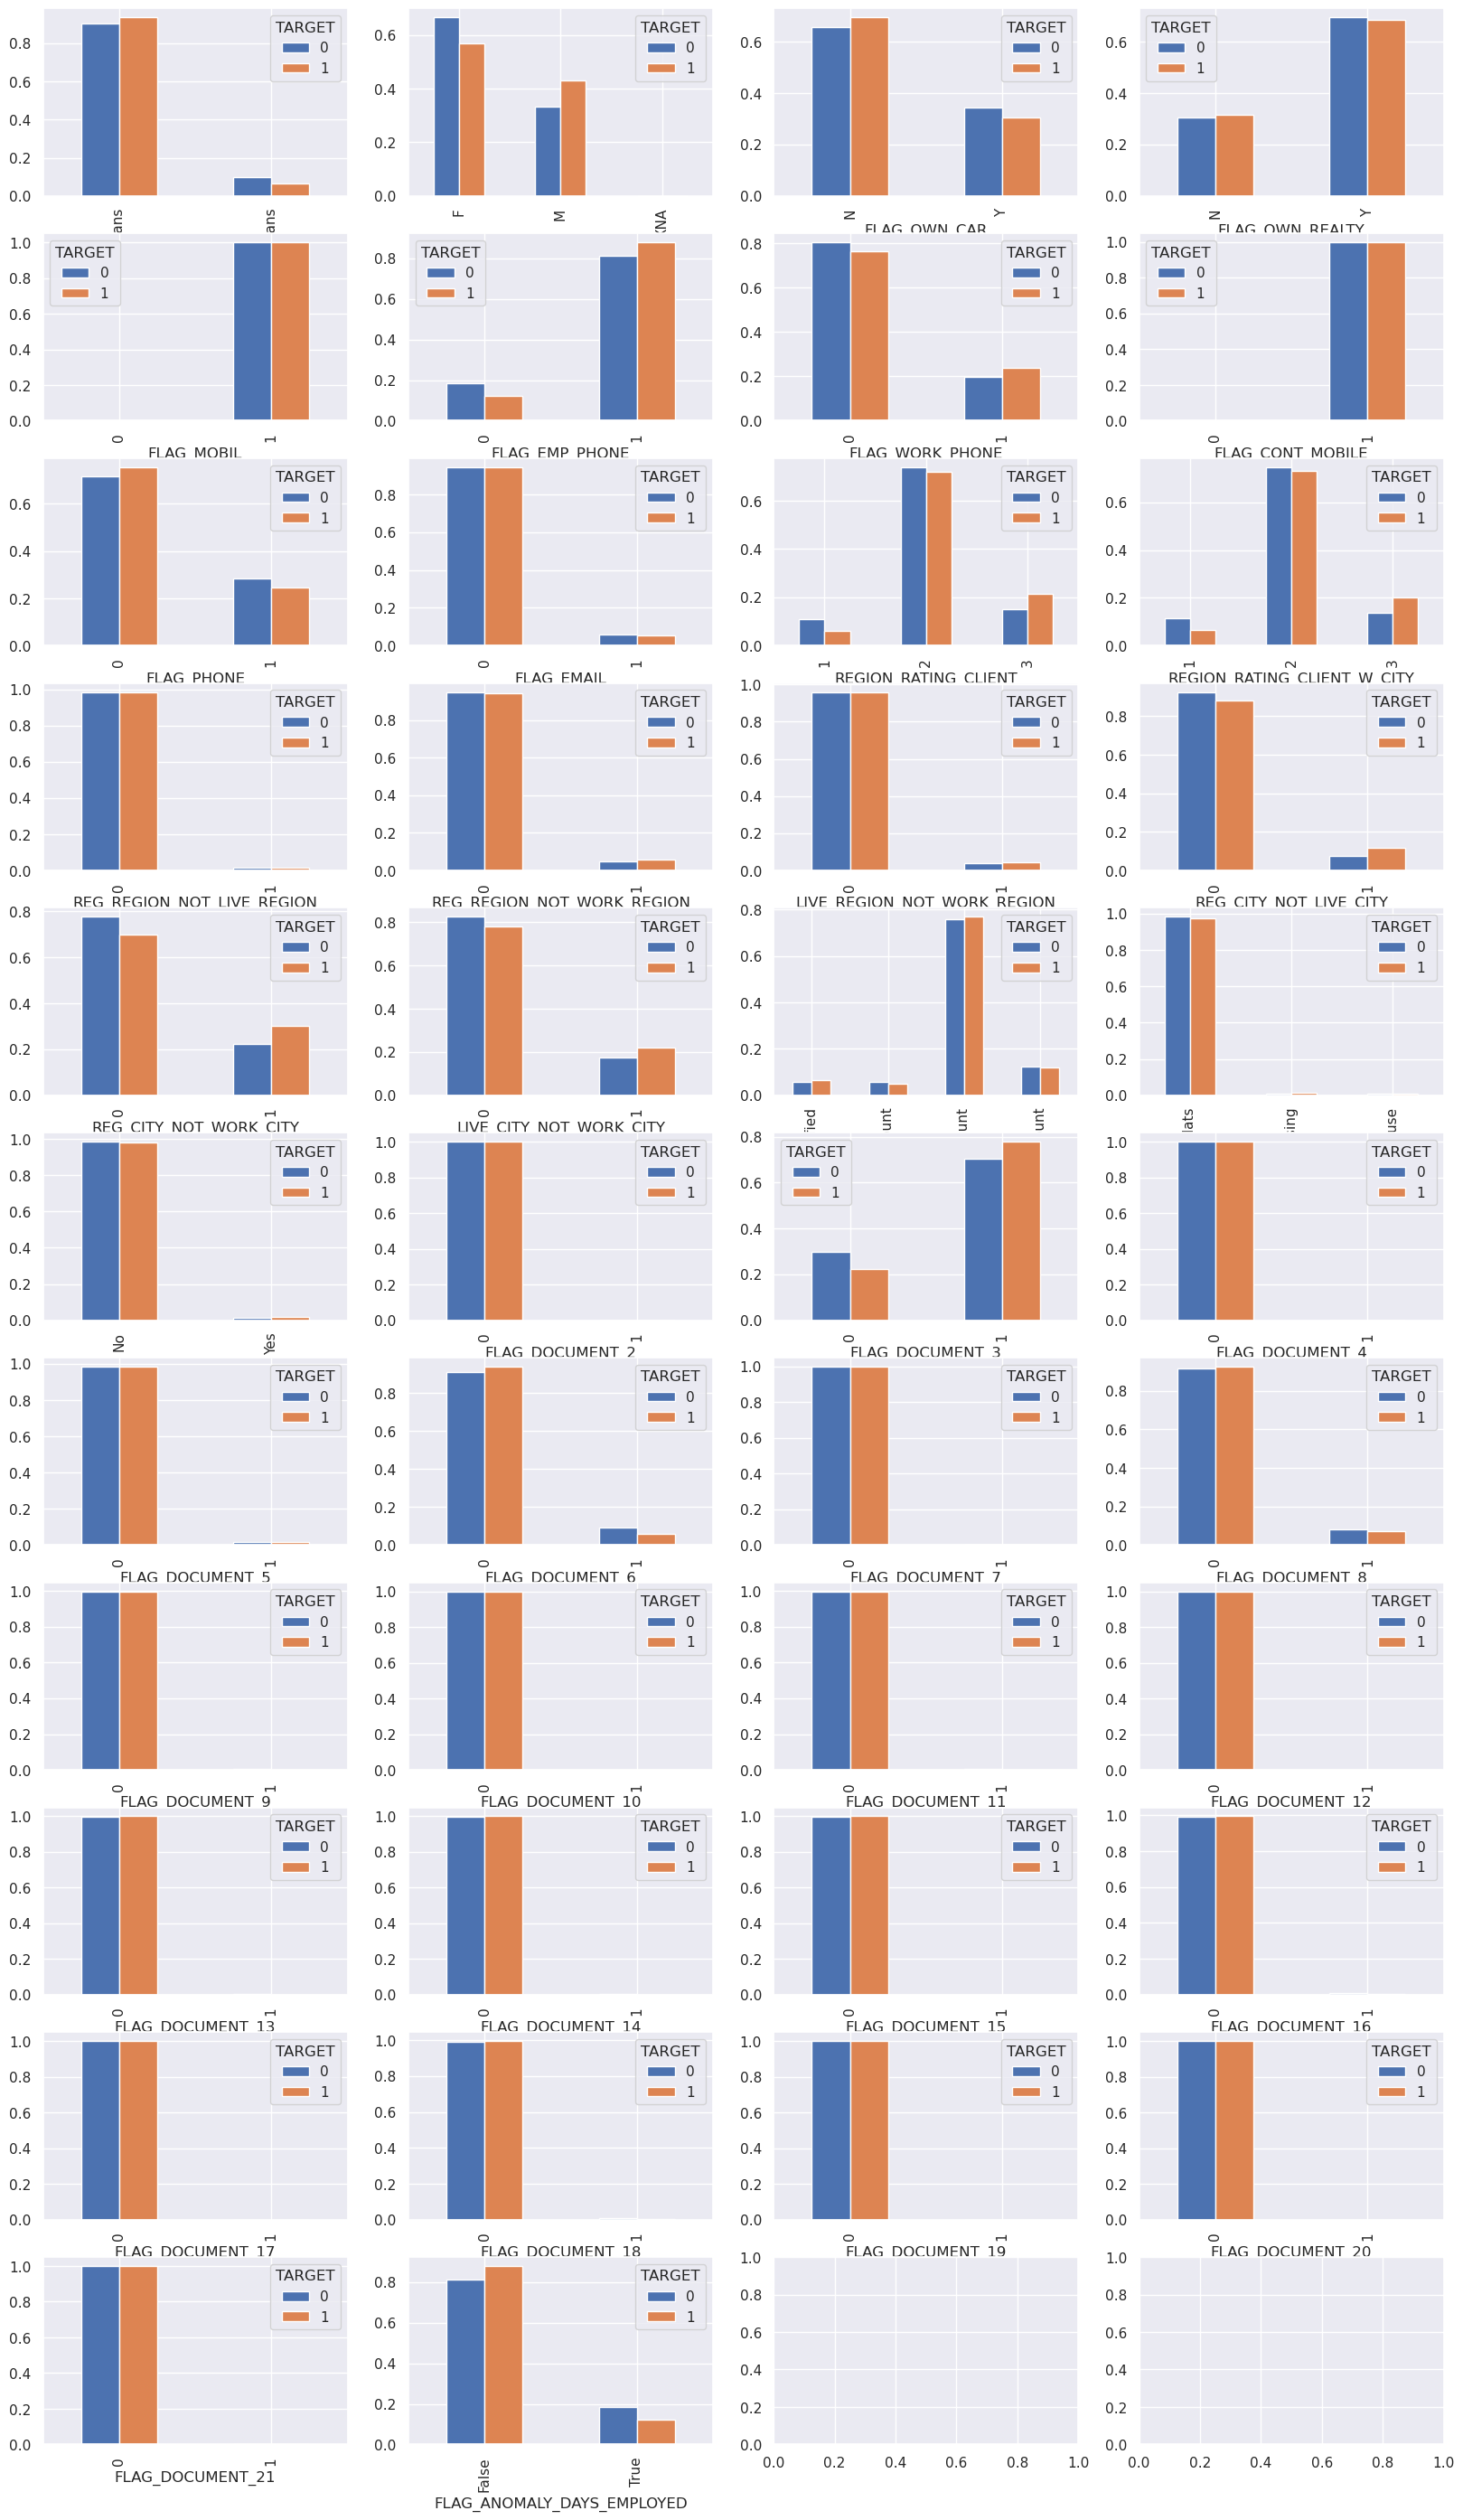

In [38]:
not_float_cols = app_train.select_dtypes(["int", "bool", "object"]).nunique()
low_cardinality = not_float_cols[not_float_cols <= 4].index.to_list()
low_cardinality.remove("TARGET")

cols = 4
rows = math.ceil(len(low_cardinality) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20, 35))

grp = app_train.groupby("TARGET")
for r in range(rows):
    for c in range(cols):
        idx = r * cols + c
        if idx < len(low_cardinality):
            i = low_cardinality[idx]
            grp[i].value_counts(normalize=True).unstack().T.plot.bar(
                ax=axes[r, c], legend=True
            )
        else:
            break

#### Higher cardinality

In [39]:
obj_cols = app_train.select_dtypes("object").nunique()
high_cardinality = obj_cols[(obj_cols > 4) & (obj_cols < 20)].index.to_list()

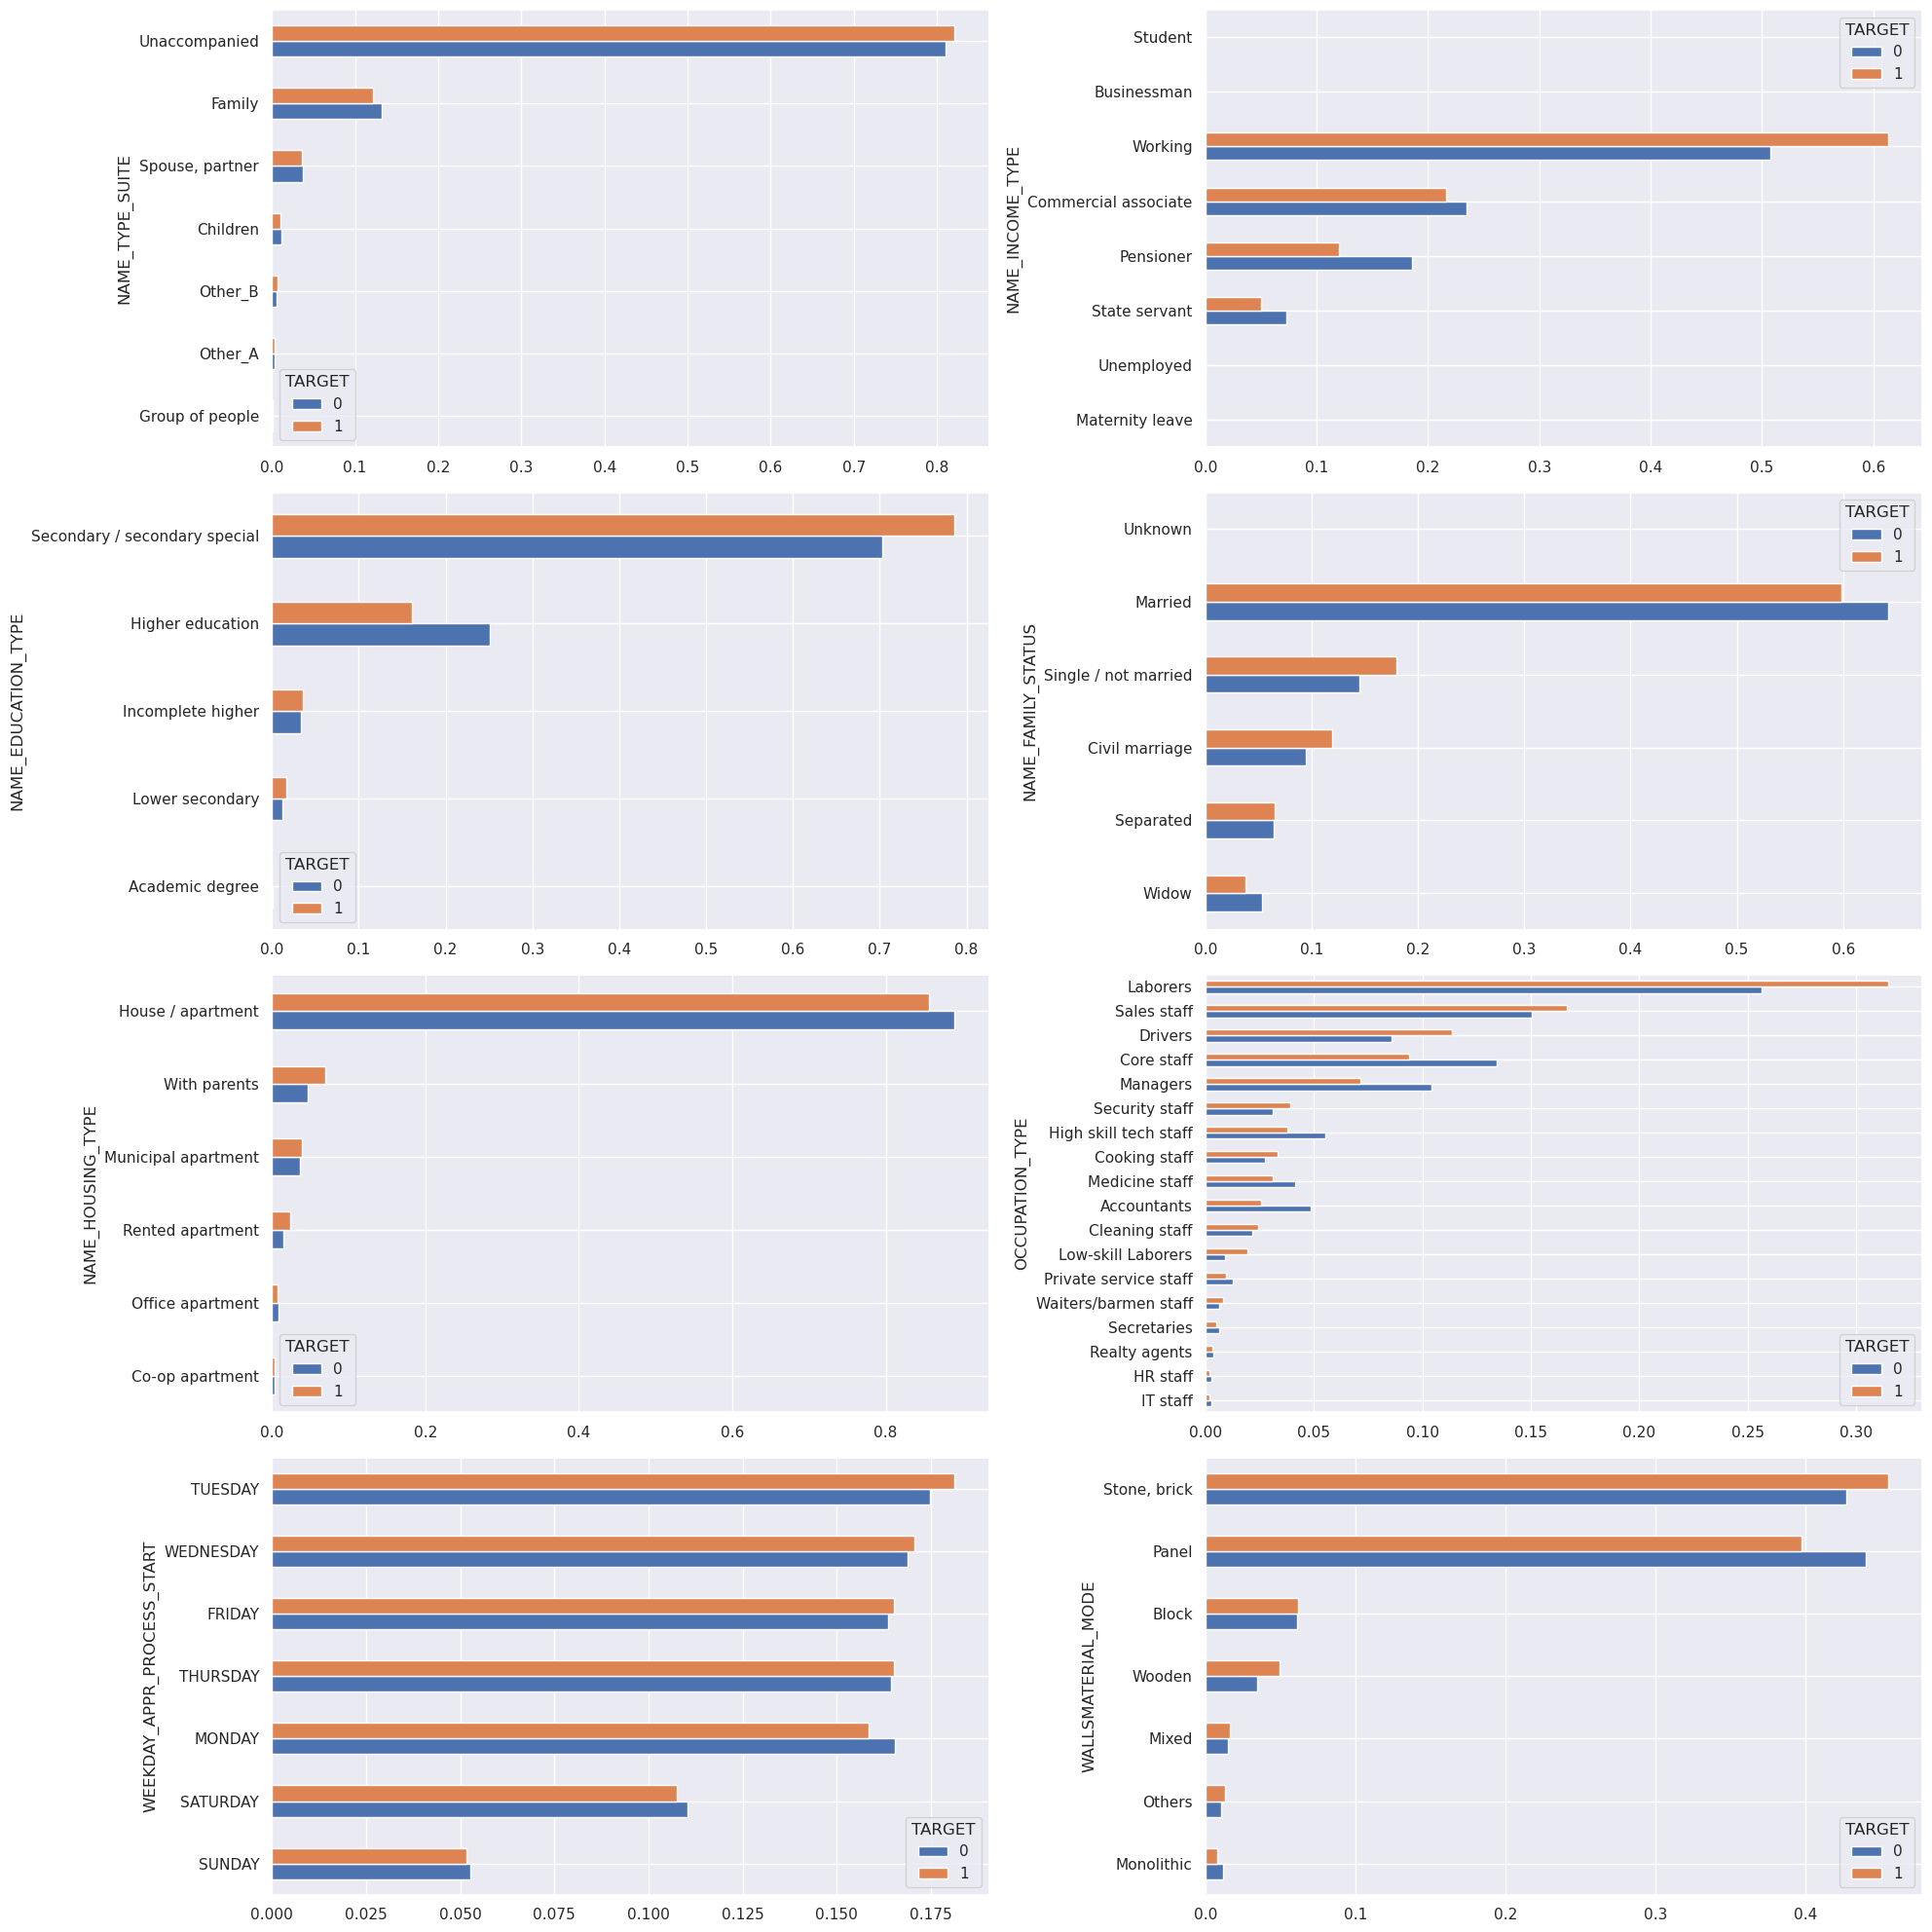

In [40]:
cols = 2
rows = math.ceil(len(high_cardinality) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

grp = app_train.groupby("TARGET")
for r in range(rows):
    for c in range(cols):
        idx = r * cols + c
        if idx < len(high_cardinality):
            i = high_cardinality[idx]
            grp[i].value_counts(normalize=True).unstack().T.sort_values(by=1).plot.barh(
                ax=axes[r, c], legend=True
            )
        else:
            break
plt.tight_layout()
# app_train.groupby("TARGET")["NAME_INCOME_TYPE"].value_counts(
#     normalize=True
# ).unstack().T.sort_values(by=1).plot.barh();

In [41]:
# app_train.groupby("TARGET")["OCCUPATION_TYPE"].value_counts(
#     normalize=True
# ).unstack().T.sort_values(by=1).plot.barh();

### Numeric features

#### Correlation Matrix

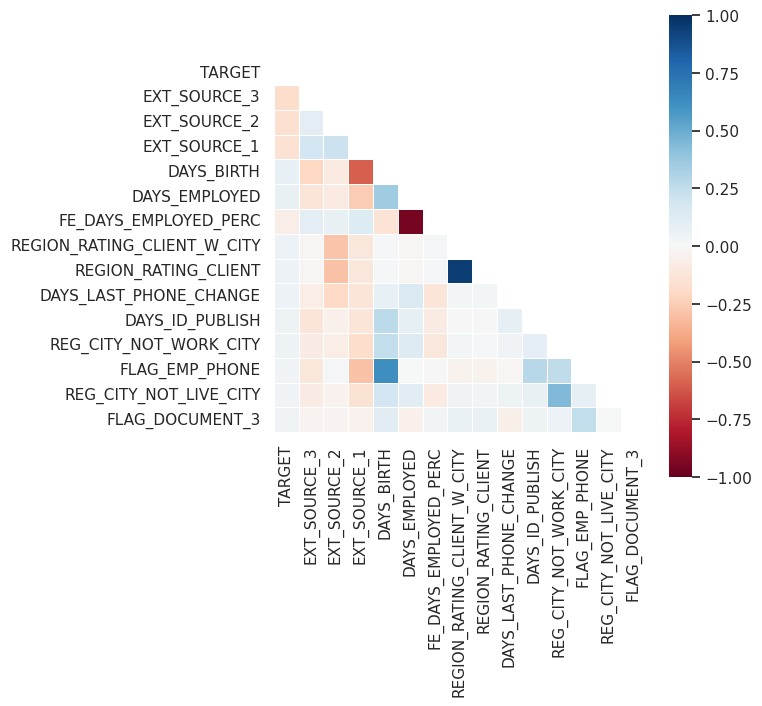

In [42]:
# Select only features with highest correlation to target
top_target_corr = (
    app_train.select_dtypes(np.number)
    .corrwith(app_train.TARGET)
    .abs()
    .sort_values(ascending=False)
    .head(15)
    .index
)

plt.figure(figsize=(6, 6))
sns.set_theme(style="white")  # for white background
sns.heatmap(
    app_train[top_target_corr].corr(),
    # shape
    mask=np.triu(app_train[top_target_corr].corr()),
    square=True,
    linewidths=0.6,
    # diverging colormap
    cmap=plt.cm.RdBu,
    center=0,
    vmin=-1,
    vmax=1,
    # annotations
    # annot=True,
    # annot_kws={"size": 20},
    # fmt=".2f",
    # cbar_kws={"shrink": 0.5},
)
plt.show();

In [43]:
get_definition("EXT_SOURCE_3")

,EXT_SOURCE_3
Description,Normalized score from external data source
Special,normalized
Table,application_{train|test}.csv


#### Distributions by target

/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

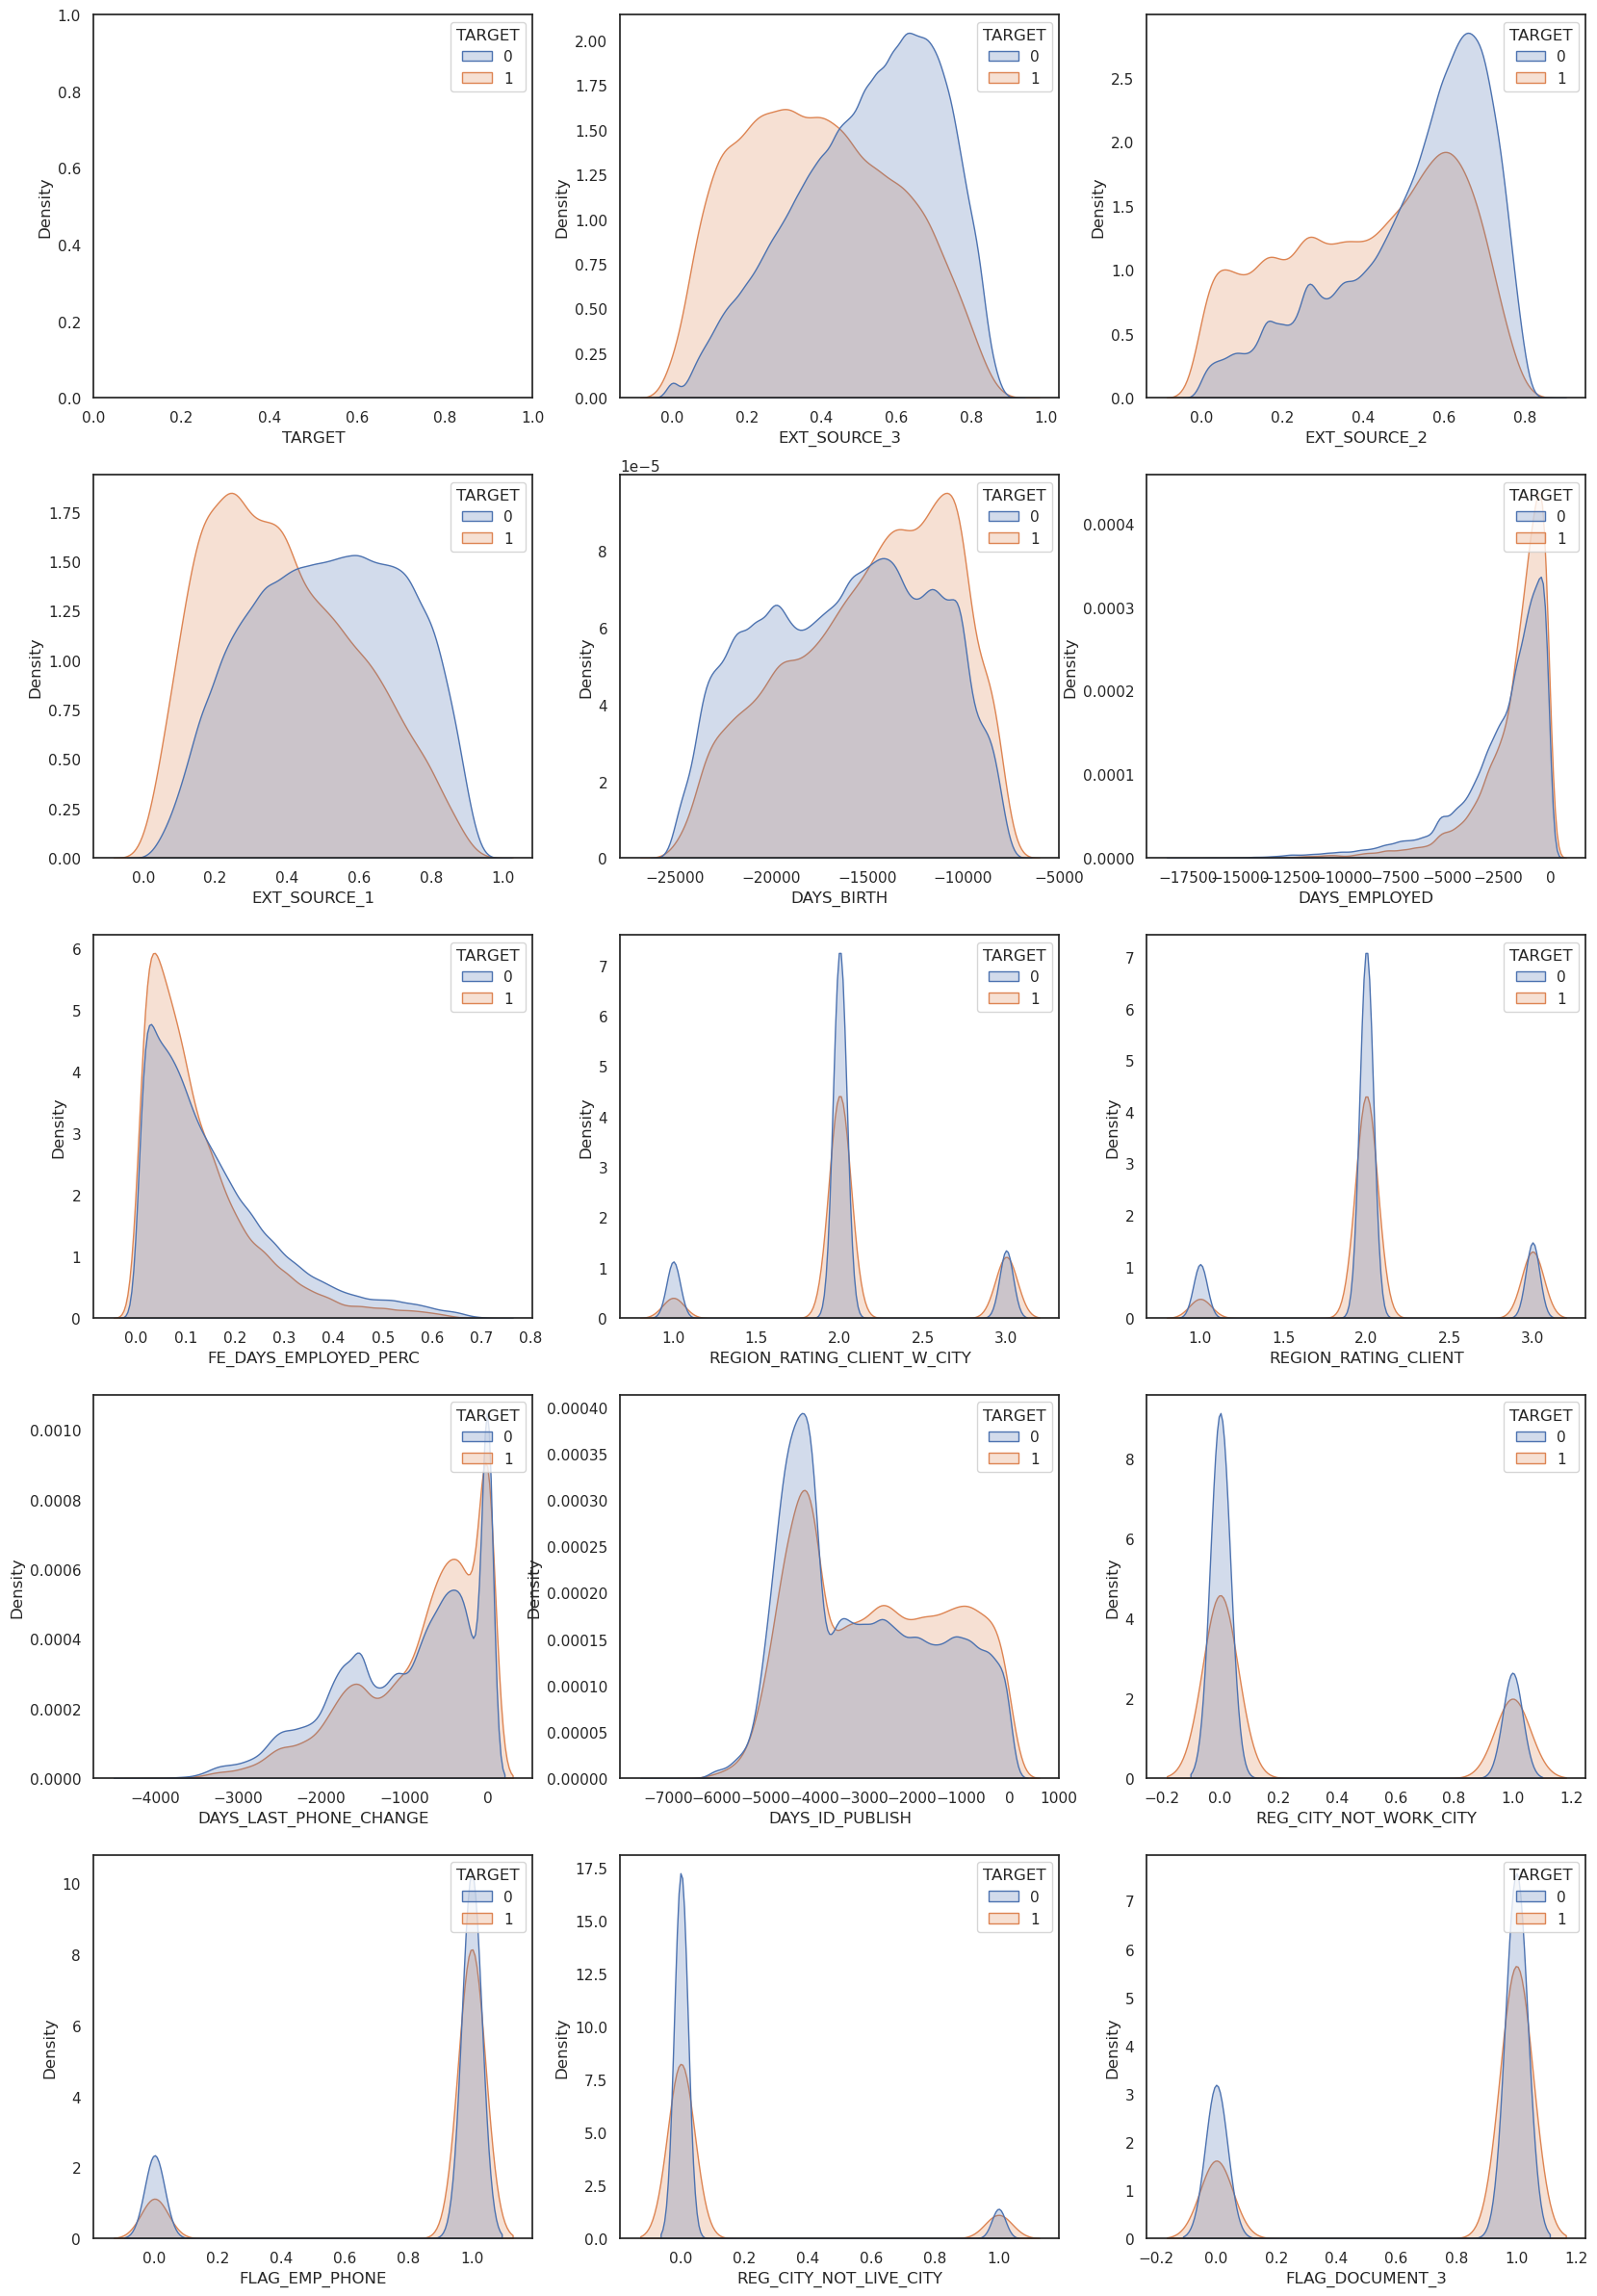

In [44]:
cols = 3
rows = int(len(top_target_corr) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20, 30))

for r in range(rows):
    for c in range(cols):
        sns.kdeplot(
            app_train[top_target_corr],
            x=top_target_corr[r * 3 + c],
            hue="TARGET",
            fill=True,
            common_norm=False,
            ax=axes[r, c],
            warn_singular=False,
        )

# Encode non-numeric features

## Label Encoding for categories with 2 labels

In [45]:
# categorical features with only 2 classes are label-encoded
le = LabelEncoder()
for col in app_train:
    if app_train[col].dtype == "object":
        if app_train[col].nunique(dropna=False) <= 2:
            print(col, app_train[col].unique(), "-> ", end="")
            # train
            app_train[col] = le.fit_transform(app_train[col])
            print(app_train[col].unique())

NAME_CONTRACT_TYPE ['Cash loans' 'Revolving loans'] -> [0 1]
FLAG_OWN_CAR ['N' 'Y'] -> [0 1]
FLAG_OWN_REALTY ['Y' 'N'] -> [1 0]


## One-Hot encoding for categories with more than 2 labels

In [46]:
app_train.dtypes.value_counts()

float64    71
int64      42
object     13
bool        1
Name: count, dtype: int64

In [47]:
app_train.select_dtypes("object").nunique(dropna=False)

CODE_GENDER                    3
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               19
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             5
HOUSETYPE_MODE                 4
WALLSMATERIAL_MODE             8
EMERGENCYSTATE_MODE            3
dtype: int64

In [48]:
print(app_train.shape)
app_train = pd.get_dummies(app_train)
print(app_train.shape)

(307511, 127)
(307511, 248)


# Save transformed data

In [49]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Columns: 248 entries, TARGET to EMERGENCYSTATE_MODE_Yes
dtypes: bool(135), float64(71), int64(42)
memory usage: 315.1 MB


In [50]:
# save using pickle to keep exact dtypes (csv will result in bigger files and higher memory footprint)
app_train.to_pickle("../data/processed/app_train_cleaned.pkl")
app_train.sample(frac=0.01).to_pickle("../data/processed/app_train_cleaned_sample.pkl")